In [1]:
import os
import torch
import sys

sys.path.append(os.path.realpath('./..'))

from model import ClipCaptionModel, ClipCaptionPrefix, MappingType
from configuration import Config
from data_utils.refcoco import build_dataset
from torch.utils.data import DataLoader
from generate_utils import generate_beam, generate2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/simeon/.anaconda3/envs/context_representations/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = Config()
model_path = '../checkpoints/refcoco_prefix-000.pt'

prefix_length = config.prefix_length
prefix_dim = 640 if config.is_rn else 512
config.mapping_type = {'mlp': MappingType.MLP, 'transformer': MappingType.Transformer}[config.mapping_type]
if config.only_prefix:
    model = ClipCaptionPrefix(prefix_length, clip_length=config.prefix_length_clip, prefix_size=prefix_dim,
                                num_layers=config.num_layers, mapping_type=config.mapping_type)
    print("only prefix")
else:
    model = ClipCaptionModel(prefix_length, clip_length=config.prefix_length_clip, prefix_size=prefix_dim,
                                num_layers=config.num_layers, mapping_type=config.mapping_type)
    print("both prefix and GPT")
    sys.stdout.flush()

model.load_state_dict(torch.load(model_path, map_location="cpu")) 

model = model.eval() 
device = 'cuda' if torch.cuda.is_available() else "cpu"
model = model.to(device)

both prefix and GPT


In [26]:
dataset = build_dataset(
    transform=model.backbone.preprocess,
    tokenizer=model.tokenizer,
    ref_dir= os.path.join(config.ref_base, config.dataset),
    coco_dir=config.coco_dir,
    verbose=config.verbose,
    mode='validation',
    return_unique=True
)

val_dataloader = DataLoader(dataset, batch_size=1, shuffle=False, drop_last=False)

Initialize Dataset with mode: val 
transformation: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f4578907370>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
) 
entries: 10834 
return unique: True 



In [27]:
data_iterator = iter(val_dataloader)

In [70]:
ann_id, *encoder_input, tokens, mask = next(data_iterator)
target, context, loc = encoder_input
tokens, mask, target = tokens.to(device), mask.to(device), target.to(device, dtype=torch.float32)

In [71]:
use_beam_search = False

prefix = model.backbone(target)
prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

with torch.no_grad():
    prefix = model.backbone(target)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix, generated_tokens = generate_beam(model, model.tokenizer, embed=prefix_embed)
else:
    generated_text_prefix, generated_tokens = generate2(model, model.tokenizer, embed=prefix_embed)


print('\n')
print(generated_text_prefix)

100%|██████████| 1/1 [00:00<00:00,  3.08it/s]



person on left<|endoftext|>


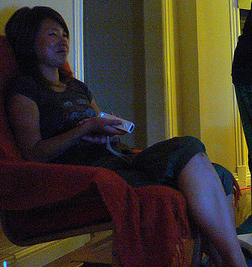

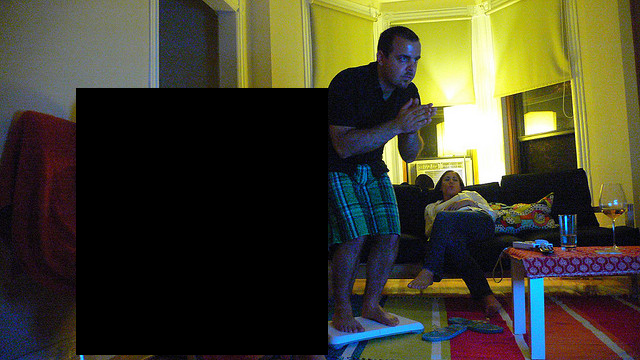

person in chair at left


In [72]:
target_img, context_img, gt_caption = dataset.get_imgs_from_ann_id(ann_id.item())

display(target_img)
display(context_img)
print(gt_caption)